In [1]:
# log-bin a density
# log-bin a function

In [2]:
import numpy as np
import math 
import matplotlib.pyplot as plt
from collections import defaultdict
from statistics import mean
from scipy.sparse import dok_matrix, csr_matrix, triu, tril
from random import randint
from tqdm.notebook import tqdm

## Functions

In [3]:
################################################# Problem 2.1 ##################################################################
def distributionBin(x: 'input data',
                    B: 'number of bins'
                   ):
    
    """
    :param x: (list) list of real-valued integers interpreted as the input data sampled from a presumed heavy-tail distribution
    :param B: (positive int) number of log-scaled bins to create a histogram from x
    
    distributionBin: Tuple, int -> Tuple, Tuple[Float] 
    
    distributionBin takes a list of input data :x: assumed to be sampled from some heavy-tailed distribution and bins in :B: log
    sized bins in such a way that the output function *integrates* to 1. The output is a list of bin-midpoints X and the binned
    estimated distribution values Y. 
    """
    
    xmin = min(x)
    xmax = max(x)
    
    # creating the B+1 bin edges
    bin_edges = np.logspace(np.log10(xmin), np.log10(xmax), num=B+1)
    
    # using numpy's histogram function get distributions
    density, _ = np.histogram(x, bins=bin_edges, density=True)
    
    # obtaining bin midpoints for cleaner absciss
    log_be = np.log10(bin_edges)
    xout = 10**((log_be[1:] + log_be[:-1])/2)
    
    return xout, density

In [4]:
################################################# Problem 2.2 ##################################################################
def functionBin(x: 'preimage',
                y: 'function output for some function y | y_i=y(x)',
                B: 'number of bins'
               ):
    
    """
    :param x: (list) list of real-valued numbers interpreted as the preimage of the function y(x)
    :param y: (list) list of real-valued numbers interpreted as the values of function y applied to each input value in x
    :param B: (positive int) number of log-scaled bins to create a histogram 
    
    functionBin: Tuple, Tuple, int -> Tuple, Tuple
    
    functionBin takes an ordered list of sampled input values :x: and their corresponding outputs under some function :y: (
    i.e. y(x)) and bins the input values into :B: log sized bins, averaging the output values within each bin. The output is 
    the bin-midpoints X and the binned outputs. 
    
    """
    
    xmin = min(x)
    xmax = max(x)
    
    # creating the B+1 bin edges
    bin_edges = np.logspace(np.log10(xmin), np.log10(xmax), num=B+1)
    
    # obtaining bin midpoints for cleaner absciss
    log_be = np.log10(bin_edges)
    bm = 10**((log_be[1:] + log_be[:-1])/2)
    
    # creating (input, output) pairs and sorting by input value
    fpairs = list(zip(x,y))
    fpairs.sort(key=lambda x: x[0])
    
    # creating (label, boundary) pairs using midpoint and right boundary for each bin
    mid_redge_pairs = list(zip(bm, bin_edges[1:]))
    
    # dictionary of values where key corresponds to the bin and values are those which fit in the bin 
    bin_out_list = defaultdict(list)
    
    idx = 0
    for mid, redge in tqdm(mid_redge_pairs, desc='Binning Function'):
        while (fpairs[idx][0] < redge) & (idx < len(fpairs)-1):
            bin_out_list[mid].append(fpairs[idx])
            idx += 1
    
    # adding the last value
    bin_out_list[list(bin_out_list.keys())[-1]].append(fpairs[-1])
    
    xout = list(bin_out_list.keys())
    
    # y value is the average of each bin
    yout = [mean([i[1] for i in b]) for b in bin_out_list.values()]
    
    return xout, yout

In [5]:
################################################# Problem 2.3 ##################################################################
def simpleSF(n: 'graph size' = 10**4,
             s: 'number of samples' = 10, 
             sparse: 'choice of numpy vs. scipy sparse matrix' = False
            ):
    
    """
    :param n: (positive int) total number of nodes in the desired graph after completing its percolation 
    :param s: (positive int) total number of graphs created
    :param sparse: (boolean) False maps output to dense numpy ndarrays, True maps them to scipy sparse csr_matrix
    
    simpleSF: Int, Int, Bool -> Tuple[np.ndarray OR scipy.sparse.csr_matrix] 
    
    simpleSF takes a value for the size of the graph :n: and the number of samples :s: and percolates :s: scale-free graphs of 
    size :n: by randomly selecting an edge E := (i,j) and attaching new incoming nodes to both i and j. The output is a list of 
    :s: :n: x :n: matrices which act as the adjacency matrix of each sample graph. Choosing scipy sparse matrix allows for 
    larger graph sizes. 
    """
    
    outlist = list()
    pbar = tqdm(range(s), desc=f"Generating Samples")
    
    for i in pbar:
    
        # edgelist
        edgelist = {(0,1)}
        
        # selecting a random edge and making the incident nodes the fruits of an incoming cherry to create a triangle 
        # process repeats until t == n 
        t = 2
        while t < n:
            m = randint(0, len(edgelist)-1)
            i,j = list(edgelist)[m]
            edgelist = edgelist | {(i, t), (j, t)}
            t += 1
            
        # mapping corresponding matrix values for all pairs in edgelist from 0 -> 1
        if sparse:
            A = dok_matrix((n, n), dtype=int)
            for e in edgelist:
                A[e] = 1

            # currently only have upper triangle, so making the matrix symmetric about the main diagonal 
            # triu and tril authomatically change it from dok_matrix to csr_matrix
            A = triu(A) + tril(A.T)

        else:
            A = np.zeros((n,n))
            for e in edgelist:
                A[e] = 1

            # currently only have upper triangle, so making the matrix symmetric about the main diagonal
            A = np.triu(A) + np.tril(A.T)
            
        outlist.append(A)
            
    return outlist
    
    

## Tests

In [6]:
import networkx as nx
import itertools

Generating Samples:   0%|          | 0/10 [00:00<?, ?it/s]

Binning Function:   0%|          | 0/20 [00:00<?, ?it/s]

Binning Function:   0%|          | 0/20 [00:00<?, ?it/s]

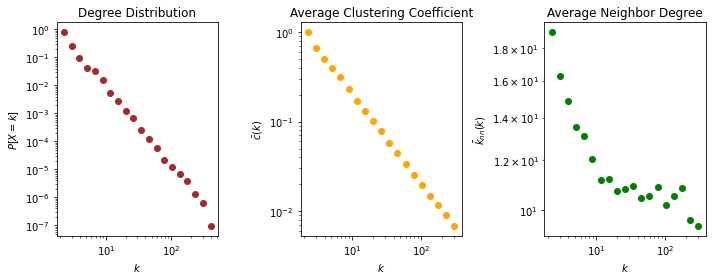

In [7]:
################################################# Problem 2.4 ##################################################################

# creating graph ensemble G 
G = simpleSF(sparse=True)

# setting number of bins
num_bins = 20

# preparing the plots

fig, axs = plt.subplots(1, 3)

################ plotting degree distribution #################### 
degrees = list()
for g in G: 
    # compressing ensemble by concatenating all degrees of all graphs into one degree sequence
    degrees.extend(g.sum(axis=0).tolist()[0])
    
    
# binning into :num_bins: bins using function from 2.1  
dist_x, dist_y = distributionBin(degrees, num_bins)

# plotting
axs[0].loglog(dist_x, dist_y, 'o', color='brown')
axs[0].set_title('Degree Distribution')
axs[0].set_ylabel(r'$P[X=k]$')
axs[0].set_xlabel(r'$k$')

################ plotting avg. clustering #################### 

# using networkx to get average clustering and average neighbor degree
indexed_node_degrees = list()
indexed_clustering = list()
indexed_average_degree = list()

for g in G: 
    # this needs to be np.from_numpy_matrix if not sparse 
    graph = nx.from_scipy_sparse_array(g)
    for node in graph.nodes:
        indexed_node_degrees.append(graph.degree(node))
        indexed_clustering.append(nx.clustering(graph, nodes=[node])[node])
        indexed_average_degree.append(nx.average_neighbor_degree(graph, nodes=[node])[node])
    
# Using the function from 2.2 to plot these values
c_x, c_y = functionBin(indexed_node_degrees, indexed_clustering, num_bins)
kk_x, kk_y = functionBin(indexed_node_degrees, indexed_average_degree, num_bins)
    
axs[1].loglog(c_x, c_y, 'o', color='orange')
axs[1].set_title('Average Clustering Coefficient')
axs[1].set_xlabel(r'$k$')
axs[1].set_ylabel(r'$\bar{c}(k)$')

axs[2].loglog(kk_x, kk_y, 'o', color='green')
axs[2].set_title('Average Neighbor Degree')
axs[2].set_xlabel(r'$k$')
axs[2].set_ylabel(r'$\bar{k}_{nn}(k)$')

fig.set_size_inches(10, 4, forward=True)
fig.tight_layout()